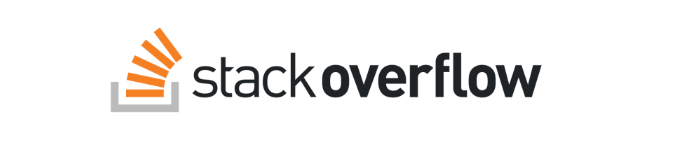

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import gc
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
# Download the required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

from pickle import dump

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("QueryResults_MLsupervisee.csv")
print(df.shape)

(40682, 7)


In [3]:
df

,Tags_filtered,Tags_filtered_len,Words_filtered,Words_filtered_len,Texte_len,Tags_len,Tags_len_ratio
0,iphone objective-c,2.0,use try iphone,3.0,14,18,1.0
1,java xml,2.0,content xml file xml know type xml use java ap...,33.0,169,8,21.0
2,database,1.0,set database like think would way web service ...,43.0,228,8,28.0
3,java,1.0,change see also java however seem work follow ...,27.0,155,4,39.0
4,ios macos,2.0,load file source macos io question use io maco...,111.0,585,9,65.0
...,...,...,...,...,...,...,...
40677,c# wpf,2.0,wpf view app xml see view net however case mak...,27.0,151,6,25.0
40678,ios objective-c,2.0,json json data url string url return code want...,44.0,245,15,16.0
40679,javascript node.js,2.0,javascript j different path use code something...,8.0,53,18,3.0
40680,java android unit-testing,3.0,android test class fail compile error write an...,36.0,202,25,8.0


In [4]:
# Replace spaces with commas in 'Tags' and 'Text' columns
df['Tags'] = df['Tags_filtered'].str.replace(' ', ', ')
df['Text'] = df['Words_filtered'].str.replace(' ', ', ')

In [5]:
def add_brackets(s):
    return '[' + s + ']'

In [6]:
df['Text'] = df['Text'].apply(add_brackets)
#df['Tags'] = df['Tags'].apply(add_brackets)

In [7]:
df

,Tags_filtered,Tags_filtered_len,Words_filtered,Words_filtered_len,Texte_len,Tags_len,Tags_len_ratio,Tags,Text
0,iphone objective-c,2.0,use try iphone,3.0,14,18,1.0,"iphone, objective-c","[use, try, iphone]"
1,java xml,2.0,content xml file xml know type xml use java ap...,33.0,169,8,21.0,"java, xml","[content, xml, file, xml, know, type, xml, use..."
2,database,1.0,set database like think would way web service ...,43.0,228,8,28.0,database,"[set, database, like, think, would, way, web, ..."
3,java,1.0,change see also java however seem work follow ...,27.0,155,4,39.0,java,"[change, see, also, java, however, seem, work,..."
4,ios macos,2.0,load file source macos io question use io maco...,111.0,585,9,65.0,"ios, macos","[load, file, source, macos, io, question, use,..."
...,...,...,...,...,...,...,...,...,...
40677,c# wpf,2.0,wpf view app xml see view net however case mak...,27.0,151,6,25.0,"c#, wpf","[wpf, view, app, xml, see, view, net, however,..."
40678,ios objective-c,2.0,json json data url string url return code want...,44.0,245,15,16.0,"ios, objective-c","[json, json, data, url, string, url, return, c..."
40679,javascript node.js,2.0,javascript j different path use code something...,8.0,53,18,3.0,"javascript, node.js","[javascript, j, different, path, use, code, so..."
40680,java android unit-testing,3.0,android test class fail compile error write an...,36.0,202,25,8.0,"java, android, unit-testing","[android, test, class, fail, compile, error, w..."


# Models supervisés

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

## Réduction dimentionelle
**PCA (Principal Component Analysis)** et **TruncatedSVD (Truncated Singular Value Decomposition)** sont deux techniques de réduction de dimensionnalité couramment utilisées en apprentissage automatique. Bien qu'elles soient toutes deux utilisées pour réduire la dimensionnalité d'un ensemble de données, il y a des différences importantes entre les deux.

La principale différence est que PCA est une technique linéaire, tandis que TruncatedSVD est une technique non linéaire. PCA trouve les composantes principales qui capturent la plus grande variabilité linéaire des données, tandis que TruncatedSVD trouve les k valeurs singulières les plus importantes d'une matrice, qui sont utilisées pour réduire la dimensionnalité.

De plus, TruncatedSVD peut être utilisé pour les matrices creuses, tandis que PCA ne peut pas. En effet, la plupart des implémentations de TruncatedSVD sont optimisées pour les matrices creuses, tandis que PCA ne l'est pas.

Enfin, TruncatedSVD est plus rapide que PCA pour les grandes matrices, car il ne calcule que les k valeurs singulières les plus importantes, tandis que PCA calcule toutes les composantes principales. Cependant, TruncatedSVD peut ne pas être aussi précis que PCA pour des matrices de petites ou moyennes tailles, car il ne capture pas nécessairement toute la variabilité linéaire des données.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

In [10]:
# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                    min_df=2, 
                                    stop_words='english')


# Fit and transform the TF-IDF matrix
X = tfidf_vectorizer.fit_transform(df['Text'])

Text(0.5, 1.0, 'Eboulis des valeurs propres')

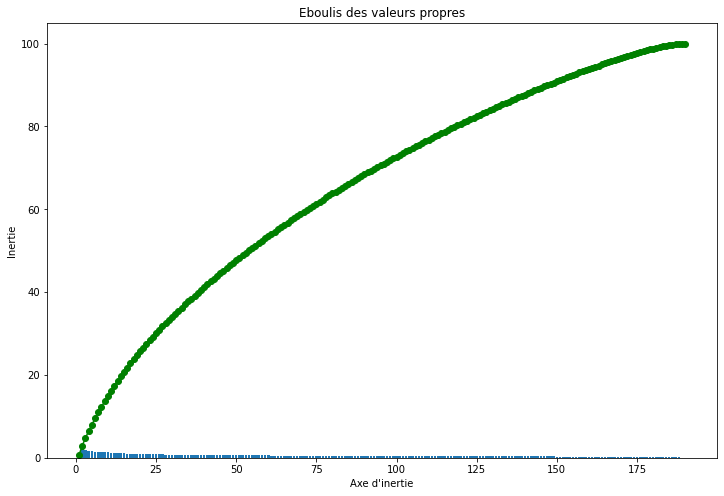

In [11]:
clf = TruncatedSVD(190)
Xpca = clf.fit_transform(X)

var_expl = clf.explained_variance_ratio_*100

plt.figure(figsize=(12,8))
plt.bar(np.arange(len(var_expl))+1, var_expl)
plt.plot(np.arange(len(var_expl))+1, var_expl.cumsum(),c="green",marker='o')
plt.xlabel("Axe d'inertie")
plt.ylabel("Inertie")
plt.title("Eboulis des valeurs propres")

In [12]:
print ("Proportion of Variance Explained : ", clf.explained_variance_ratio_)  
    
out_sum = np.cumsum(clf.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.00670062 0.02277014 0.01818596 0.01709791 0.01544275 0.01474136
 0.01450281 0.01381611 0.0130213  0.01281475 0.01256076 0.0121689
 0.0119226  0.01092666 0.0107815  0.01024523 0.01009007 0.00977614
 0.009616   0.00956289 0.00908791 0.0090341  0.00878702 0.00864787
 0.00830686 0.00823455 0.00821241 0.00790857 0.00782162 0.0076627
 0.00755651 0.00740423 0.00738518 0.00730645 0.00721268 0.00714335
 0.00703501 0.00694247 0.00685059 0.00682577 0.00678965 0.00673468
 0.00663977 0.0065813  0.00650737 0.00643786 0.00632867 0.00630756
 0.00627184 0.00620301 0.00609515 0.00602248 0.00591473 0.00588578
 0.00583342 0.00582109 0.00572461 0.00569358 0.00565535 0.0055819
 0.0055442  0.00552107 0.00544882 0.00542503 0.00537334 0.00531042
 0.00524576 0.00519832 0.00515756 0.00514318 0.00513268 0.00503898
 0.0050288  0.00498699 0.0049445  0.00494013 0.00492012 0.00489243
 0.00485649 0.00482033 0.00477711 0.00473959 0.00471686 0.00467684
 0.00464272 0.00461257 0.0045

## Tf idf
* TF = nombre de fois où le mot est dans le document / nombre de mots dans le document
* IDF = nombre de documents / nombre de documents où apparaît le mot

In [13]:
%%time
# Define X and y
X = df['Text']

# Initialize the "CountVectorizer" TFIDF for text_comb
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.97,
                             min_df= 3,
                             tokenizer=None)
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

Shape of X for Full_doc: (40682, 212)
Wall time: 9.26 s


## Classification multi-classes

La classification multi-classes est une tâche dans laquelle les exemples sont affectés à une classe parmi plus de deux.

Classification binaire : Tâches de classification à deux classes.
Classification multi-classes : Tâches de classification comportant plus de deux classes.
Certains algorithmes sont conçus pour les problèmes de classification binaire. En voici quelques exemples :

* Régression logistique
* SVM

In [14]:
# Conversion des labels en listes d'éléments pour la classification multi-label
y = df["Tags"].apply(lambda x: x.split(",")).tolist()

In [15]:
%%time
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print(f"Shape of y:              {y_binarized.shape}")

Shape of y:              (40682, 92)
Wall time: 95.4 ms


## TF IDF

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVC

from pickle import dump

In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report

In [18]:
# Create train and test split (20%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.20, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (32545, 212)
X_test shape : (8137, 212)
y_train shape : (32545, 92)
y_test shape : (8137, 92)


Afin de comparer les modèles nous avons évalué quatre indicateurs :

* Précision : capacité à prédire correctement les tags associés à chaque document
* Recall : capacité à retourner pour chaque tags tous les documents qui y sont associés
* F1 Score : moyenne harmonique de ces deux indicateurs


Etant face à une classification multi-classes nous utilisons les version micro de ces indicateurs. Concrètement, cette version des indicateurs est calculée par classe puis agrégés là où les indicateurs macro sont calculés globalement. Lors de l’évaluation nous nous intéressons à la précision et au temps d’entraînement. Dans le cadre d’une API de suggestion de tags, la capacité d’un modèle à retourner tous les documents associés à chaque terme n’est pas essentielle. Le recall et le F1 score seront toutefois été observés pour affiner l’analyse.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

models_performance = {}


def metrics_report(model_name, test_labels, predictions, performances):
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(
        test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(
        test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + model_name + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

    performances[model_name] = {}
    performances[model_name]["micro_precision"] = micro_precision
    performances[model_name]["micro_recall"] = micro_recall
    performances[model_name]["micro_f1"] = micro_f1
    performances[model_name]["training_time"] = training_time

In [20]:
def cut_off(test_labels, y_score):
    """
    Compute threshold for predicted a probability of multi-labels 

    Parameters
    ----------------------------------------
    test_labels : array of true labels
    y_score : array of predicted labels with probability
    ----------------------------------------
    """
    n = y_score.shape[1]
    thresholds = np.zeros(n)
    # Compute fpr, tpr, thresholds and roc auc
    for j in range(n):
        # calculate roc curves
        fpr, tpr, ths = roc_curve(y_test[:, j], y_score[:, j])
        # calculate the statistic
        dis = abs(1-fpr-tpr)
        # locate the index of the lower distance
        idx = np.argmin(dis)
        thresholds[j] = ths[idx]
    threshold = thresholds.max()

    return threshold

### Model

In [26]:
# Créer le modèle de Logistic Regression
model = OneVsRestClassifier(LogisticRegression())

# Début de la mesure du temps
start_time = time.time()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Fin de la mesure du temps
end_time = time.time()
training_time = end_time - start_time

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
metrics_report("Regression_logistique_tfidf", y_test , y_pred, models_performance)

------LogisticRegression_tfidf Model Metrics-----
Accuracy: 0.1707
Hamming Loss: 0.0157
Precision:
  - Macro: 0.3839
  - Micro: 0.7002
Recall:
  - Macro: 0.1287
  - Micro: 0.2755
F1-measure:
  - Macro: 0.1787
  - Micro: 0.3954


In [27]:
pickle.dump(model, open('Logreg_model.pkl', 'wb'))

In [28]:
# seuil de classification
cut_off(y_test, y_pred)

1.0

In [29]:
# Inverse transform
threshold = cut_off(y_test,y_pred)
reg_logit_preds = (y_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(y_pred)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

In [30]:
# Créer un dataframe pour stocker les résultats
df_resultats_tfidf = pd.DataFrame()

# Ajouter les valeurs de y_test et y_pred au dataframe
df_resultats_tfidf['y_test'] = y_test_inversed
df_resultats_tfidf['y_pred'] = y_pred_inversed

In [31]:
df_resultats_tfidf

,y_test,y_pred
0,"(c++,)",()
1,"(python,)","(python,)"
2,"( python-3.x, python)","(python,)"
3,"(.net,)","(c#,)"
4,"( macos, windows)",()
...,...,...
8132,"( sql, java)",()
8133,"(python,)",()
8134,"( string, c#)","( string,)"
8135,"( algorithm, string, python)",()


### Résultats

In [32]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,micro_precision,micro_recall,micro_f1,training_time
LogisticRegression_tfidf,0.700218,0.275463,0.395383,29.861057


## Word2Vec

In [33]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

Word2vec est un groupe de modèles utilisé pour le plongement lexical (word embedding). Ces modèles ont été développés par une équipe de recherche chez Google sous la direction de Tomas Mikolov. Ce sont des réseaux de neurones artificiels à deux couches entraînés pour reconstruire le contexte linguistique des mots. La méthode est implémentée dans la bibliothèque Python Gensim.

In [34]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = X.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [35]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 212
Word2Vec trained


In [36]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 213


In [37]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (213, 300)


In [38]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           63900     
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 63,900
Trainable params: 63,900
Non-trainable params: 0
_________________________________________________________________


In [39]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

1272/1272 [==============================] - 2s 2ms/step


(40682, 300)

In [40]:
# Create train and test split (20%)
X_train, X_test, y_train, y_test = train_test_split(embeddings, y_binarized,
                                                    test_size=0.20, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (32545, 300)
X_test shape : (8137, 300)
y_train shape : (32545, 92)
y_test shape : (8137, 92)


### Model

In [ ]:
# Créer le modèle de Logistic Regression
model = OneVsRestClassifier(LogisticRegression())

# Début de la mesure du temps
start_time = time.time()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Fin de la mesure du temps
end_time = time.time()
training_time = end_time - start_time

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
metrics_report("Regression_logistique_W2V", y_test , y_pred, models_performance)

In [47]:
# seuil de classification
cut_off(y_test, y_pred)

1.0

In [48]:
# Inverse transform
threshold = cut_off(y_test,y_pred)
reg_logit_preds = (y_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(y_pred)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

In [49]:
# Créer un dataframe pour stocker les résultats
df_resultats_W2V = pd.DataFrame()

# Ajouter les valeurs de y_test et y_pred au dataframe
df_resultats_W2V ['y_test'] = y_test_inversed
df_resultats_W2V ['y_pred'] = y_pred_inversed

In [50]:
df_resultats_W2V 

,y_test,y_pred
0,"(c++,)",()
1,"(python,)",()
2,"( python-3.x, python)","(python,)"
3,"(.net,)","( multithreading, c#)"
4,"( macos, windows)",()
...,...,...
8132,"( sql, java)",()
8133,"(python,)",()
8134,"( string, c#)",()
8135,"( algorithm, string, python)","( string,)"


### Résulats

In [51]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,micro_precision,micro_recall,micro_f1,training_time
LogisticRegression_tfidf,0.700218,0.275463,0.395383,29.861057
Regression_logistique_W2V,0.640563,0.195268,0.299299,132.079161


## USE

In [52]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

In [53]:
import tensorflow_hub as hub
import os

# Set the module cache directory to a different location
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub"

Model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [54]:
def feature_USE(sentences, b_size):
    batch_size = b_size

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = Model_use(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    if idx+batch_size < len(sentences):
        feat = Model_use(sentences[idx+batch_size:len(sentences)])
        features = np.concatenate((features, feat))

    return features

In [ ]:
batch_size = 1
sentences = X.to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
features_USE.shape

In [ ]:
y_binarized.shape

In [ ]:
# Create train and test split (20%)
X_train, X_test, y_train, y_test = train_test_split(features_USE, y_binarized,
                                                    test_size=0.20, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

### Model

In [ ]:
# Créer le modèle Régression logistique
model = OneVsRestClassifier(LogisticRegression())

# Début de la mesure du temps
start_time = time.time()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Fin de la mesure du temps
end_time = time.time()
training_time = end_time - start_time

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
metrics_report("Regression_logistique_USE", y_test, y_pred, models_performance)

In [ ]:
# seuil de classification
cut_off(y_test, y_pred)

In [ ]:
# Inverse transform
threshold = cut_off(y_test,y_pred)
reg_logit_preds = (y_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(y_pred)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

In [ ]:
# Créer un dataframe pour stocker les résultats
df_resultats = pd.DataFrame()

# Ajouter les valeurs de y_test et y_pred au dataframe
df_resultats['y_test'] = y_test_inversed
df_resultats['y_pred'] = y_pred_inversed

In [ ]:
df_resultats

### Résultats

In [ ]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

## BERT

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [ ]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" 
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [ ]:
batch_size = 1
sentences = X.to_list()

In [ ]:
def feature_bert_tfh(sentences, key, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        inputs = preprocess(sentences[idx:idx+batch_size])
        feat = bert(inputs)[key]

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    if idx+batch_size<len(sentences):
        inputs = preprocess(sentences[idx+batch_size:len(sentences)])
        feat = bert(inputs)[key]
        features = np.concatenate((features,feat))      

    return features

In [ ]:
feat_bert = feature_bert_tfh(sentences, 'pooled_output',128)

In [ ]:
feat_bert.shape

In [ ]:
y_binarized.shape

In [ ]:
# Create train and test split (20%)
X_train, X_test, y_train, y_test = train_test_split(feat_bert, y_binarized,
                                                    test_size=0.20, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

### Models

In [ ]:
# Créer le modèle Régression logistique
model = OneVsRestClassifier(LogisticRegression())

# Début de la mesure du temps
start_time = time.time()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Fin de la mesure du temps
end_time = time.time()
training_time = end_time - start_time

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
metrics_report("Regression_logistique_BERT", y_test, y_pred, models_performance)

### Résultats

In [ ]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

In [ ]:
df_result = result_df.T
col_model =['micro_precision', 'micro_recall', 'micro_f1']
ax = df_result[col_model].plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(df_result.index,rotation=90, fontsize=15);
ax.set_title('Score comparison of Embeddings features with logisticregression', fontsize=15);

In [ ]:
ax = df_result['training_time'].plot.bar(figsize= (8,5),color='red');
ax.set_xticklabels(df_result.index,rotation=80, fontsize=15);
ax.set_title('Fit time of Embeddings features with logisticregression', fontsize=15);

# Models non supervisés

In [ ]:
import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import logging
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

##  Latent Dirichlet Allocation (LDA)
C’est une méthode non-supervisée générative qui se base sur les hypothèses suivantes :

* Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words) ;

* Chaque document aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres p(θm)

* Chaque mot possède une distribution associée à chaque thème p(ϕk). On peut ainsi représenter chaque thème par une probabilité sur chaque mot.

* zn représente le thème du mot wn

On peut déterminer quels sont les thèmes, les distributions de chaque mot sur les thèmes, la fréquence d’apparition de chaque thème sur le corpus.

Une représentation formelle sous forme de modèle probabiliste graphique est la suivante :

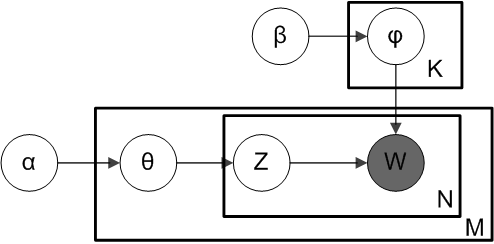

In [ ]:
# Créer une liste de listes de mots à partir de la colonne 'Words_filtered'
documents = df['Words_filtered'].apply(lambda x: x.split()).tolist()

# Créer le dictionnaire de mots avec gensim
gensim_dictionary = corpora.Dictionary(documents)

# Créer le corpus de documents sous forme de sac de mots avec le dictionnaire
corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

In [ ]:
#printing the corpus we created above.
print(corpus[:3]) 

In [ ]:
#we can print the words with their frequencies.

[[(gensim_dictionary[id], freq) for id, freq in cp] for cp in corpus[:4]] 

In [ ]:
# stock result of coherence and perplexity score
results = []

# loop for find the best topic :
for n_topics in [4, 5, 6, 7, 8, 9, 10, 11, 12]:

    # creating the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=gensim_dictionary,
                                                num_topics=n_topics,
                                                random_state=0,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto'
                                                )

    # creation score :
    Perplexity_Score = lda_model.log_perplexity(corpus)
    Coherence_Score = CoherenceModel(model=lda_model,
                                     texts=documents,
                                     dictionary=gensim_dictionary,
                                     coherence='c_v'
                                     ).get_coherence()

    # Visualize the results :
    print('-'*40)
    print(f" For {n_topics} topics :")
    print('-'*40)
    print('')

    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    print(f"Perplexity Score : {Perplexity_Score}")
    print('')

    # Compute Coherence Score
    print(f"Coherence Score : {Coherence_Score}")

    results.append([n_topics, Perplexity_Score, Coherence_Score])

In [ ]:
fig,ax= plt.subplots(figsize=(15, 15))

# 1st line :
ax.plot([line[0] for line in results],
        [line[1] for line in results],
        color = "b",
        label = 'perplexity_score')
ax.set_ylabel('perplexity_score')
ax.set_xlabel('Number of Topics')


# to have same size for score :
ax2 = ax.twinx()

# 2nd line :
ax2.plot([line[0] for line in results],
        [line[2] for line in results],
        color = "g",
        label = 'coherence_score')
ax2.set_ylabel('coherence_score')

fig.legend()

### Optimisation LDA

In [ ]:
# number of topics
num_topics = 6

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=gensim_dictionary,
                                       num_topics=num_topics)

# Define the number of top words to print for each topic
no_top_words = 20

# Print the top words in the 6 topics
for topic_idx in range(num_topics):
    print("Topic {}:".format(topic_idx))
    top_words = lda_model.get_topic_terms(topic_idx, topn=no_top_words)
    top_word_strings = [gensim_dictionary[i] for i, _ in top_words]
    print(" ".join(top_word_strings))
    print()

doc_lda = lda_model[corpus]

### Analyzing LDA model results

Maintenant que nous disposons d'un modèle entraîné, visualisons les sujets pour en faciliter l'interprétation. Pour ce faire, nous utiliserons un paquetage de visualisation populaire, pyLDAvis, qui est conçu pour aider de manière interactive à :

Mieux comprendre et interpréter les sujets individuels, et
Mieux comprendre les relations entre les sujets.
Pour (1), vous pouvez sélectionner manuellement chaque sujet pour visualiser les termes les plus fréquents et/ou les plus "pertinents", en utilisant différentes valeurs du paramètre λ. Cela peut s'avérer utile lorsque vous essayez d'attribuer un nom ou une "signification" interprétable par l'homme à chaque thème.

Pour (2), l'exploration du graphe de la distance inter-sujets peut vous aider à comprendre comment les sujets sont liés les uns aux autres, y compris une structure potentielle de plus haut niveau entre les groupes de sujets.

In [ ]:
import pyLDAvis.gensim_models
import gensim

data = pyLDAvis.gensim_models.prepare(lda_model, corpus, gensim_dictionary)

# Visualisation interactive
pyLDAvis.show(data)

## NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

In [ ]:
# Define the number of features to use
n_features = 1000

# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                    min_df=2, 
                                    max_features=n_features, 
                                    stop_words='english')

# Fit and transform the TF-IDF matrix
tfidf = tfidf_vectorizer.fit_transform(Words)

# Get the feature names from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Define the number of topics for NMF
n_components = 5

# Run NMF
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

# Define the number of top words to display for each topic
n_top_words = 20

# Display the top words for each topic
display_topics(nmf, tfidf_feature_names, n_top_words)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# Visualisation
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')